In [52]:
import numpy as np
import numba
print(numba.__version__)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt
import MicroTools.param_scan as param_scan
from MicroTools.param_scan import fast_histogram
from tqdm.notebook import tqdm  # Note the change here
# from tqdm.auto import tqdm

from ipywidgets import IntProgress
from IPython.display import display

0.58.1


In [2]:
def run_scan_osc_dec(kwargs, filename, Npoints=10, path_results = "fit_data/"):

    gvec = np.geomspace(1e-4, 3.5, Npoints)
    mvec = np.geomspace(1e-1, 1e2, Npoints)
    Ue4Sq = np.geomspace(1e-4, 0.49, Npoints)
    Umu4Sq = np.geomspace(1e-4, 0.49, Npoints)
    # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
    paramlist = param_scan.create_grid_of_params(g=gvec, m4=mvec, Ue4Sq=Ue4Sq, Um4Sq=Umu4Sq)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs)

    with Pool() as pool:
        # res = pool.map(func_scan, paramlist)
        res = np.array(list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist))))

    param_scan.write_pickle(f"{path_results}/{filename}", res)
    return res

In [2]:
# Common attributes to all osc+dec scans
kwargs_common = {
    'oscillations': True, 
    'decay': True, 
    'decouple_decay': False, 
    'include_antineutrinos': True, 
    'n_replications': 10}

# Appearance only
kwargs_apponly = {
    'disappearance': False, 
    'use_numu_MC': False,
    'undo_numu_normalization': False,
    **kwargs_common}

# Include disappearance and energy degradation
kwargs_std = {
    'disappearance': True, 
    'use_numu_MC': True,
    'energy_degradation': True, 
    'undo_numu_normalization': False,
    **kwargs_common}

#Include disappearance, but no energy degradation
kwargs_noed = {
    'disappearance': True, 
    'use_numu_MC': True,
    'energy_degradation': False, 
    'undo_numu_normalization': False,
    **kwargs_common}

#Oscillation only, no antineutrinos
kwargs_nobar_osc = {
'oscillations': True, 
'decay': False, 
'decouple_decay': False, 
'disappearance': True, 
'energy_degradation': False, 
'use_numu_MC': True, 
'undo_numu_normalization': False,
'n_replications': 10,
'include_antineutrinos': False
}

# osc+decay, no antineutrinos
kwargs_nobar = {
'oscillations': True, 
'decay': True, 
'decouple_decay': False, 
'disappearance': True, 
'energy_degradation': False, 
'use_numu_MC': True, 
'undo_numu_normalization': False,
'n_replications': 10,
'include_antineutrinos': False
}

# deGouvea's case
kwargs_deGouvea = {
'oscillations': True, 
'decay': True, 
'decouple_decay': True, 
'disappearance': True, 
'energy_degradation': True, 
'use_numu_MC': True, 
'undo_numu_normalization': False,
'n_replications': 10,
'include_antineutrinos': True
}


In [ ]:
_ = run_scan_osc_dec(kwargs_std, 'TZ_decay_dis', Npoints=2)

In [6]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
def create_grid_of_params(g, m4, Ue4Sq, Um4Sq):
    paramlist_decay = np.array(np.meshgrid(g, m4, Ue4Sq, Um4Sq)).T.reshape(-1, 4)
    return [{"g": g, "m4": m4, "Ue4Sq": Ue4Sq, "Um4Sq": Um4Sq} for g, m4, Ue4Sq, Um4Sq in paramlist_decay]

path_results = "fit_data/"
Npoints = 10

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4/4, 0.89/4, Npoints)

# Range of m4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=10, m4=y_Vec, Ue4Sq=0.05, Um4Sq=x_Vec)

# Pure oscillation method
#func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=False, use_numu_MC=True, include_antineutrinos=False)
func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs_std)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_osc, paramlist_decay)
#res = np.array(list(tqdm(pool.imap(func_2Dscan_osc, paramlist_decay), total=len(paramlist_decay))))
#np.save(f"{path_results}/App_gm4_Um4sq_osc_decay_deg_g=0.1_Ue4Sq=0.05_test", res)
np.save(f"{path_results}/g=10_std_test", res)

## Profiling over $\textrm{g}$ and $|U_{e4}|^2$ for minimal MicroBooNE $\chi^2$

'MVec = slice_marg[:,3]\n#MVec = [4 * slice_marg[i,2] * slice_marg[i,3] for i in range(len(slice_marg))]\ngm4VecT = slice_marg[:,1]**2\nfig, ax = pt.std_fig(figsize=(pt.std_figsize[0], pt.std_figsize[1]*1.5))\nxmin, xmax, ymin, ymax = 1e-4, 1, 1e-2, 1e4\nax.set_xscale(\'log\')\nax.set_yscale(\'log\')\nax.axis([xmin, xmax, ymin, ymax])\n#ax.set_ylabel(r\'$g_D m_4 [\\mathrm{eV}]$\', fontproperties=pt.font)\nax.set_ylabel(r\'$\\Delta m_{41}^2 [\\mathrm{eV^2}]$\', fontproperties=pt.font)\nax.set_xlabel(r"$|U_{\\mu 4}|^2$", fontproperties=pt.font)\n\nlevs0MB = np.min(MicroApp_chi2)\nlevsMiniB = [0, 2.30, 6.18, 11.83]\nlevsMicroB = [6.18, 1e10]\n\nax.tricontourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap=\'Blues\', alpha=1)'

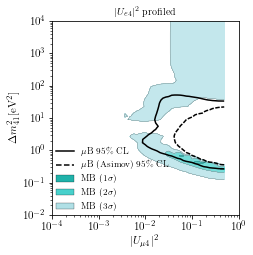

In [41]:
Npoints = 30
# Range of g for sterile decay model scanned over 1e-1 to 1e2 in 15 steps
g = np.geomspace(1e-4, 3.5, Npoints)

# Range of m scanned over 1e-1 to 1e2 in 15 steps
m = np.geomspace(1e-1, 1e2, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 0.49 in 15 steps
e = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 0.49 in 15 steps
mu = np.geomspace(1e-4, 0.49, Npoints)

data = np.load(f"{path_results}/KJK_decay_dis.pkl", allow_pickle=True)
#fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
#xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2

slice_marg = []

for i in range(Npoints):
    slice_m = data[data[:, 1] == m[i], :]
    for j in range(Npoints):
        slice_mu = slice_m[slice_m[:, 3] == mu[j], :]
        #if slice_mu[:,-2].size:
        min_entry = slice_mu[np.argmin(slice_mu[:, -2])]
        #else:
        #    continue
        slice_marg.append(min_entry)
slice_marg = np.array(slice_marg)

MiniApp_chi2 = slice_marg[:,-3]
MicroApp_chi2 = slice_marg[:,-2]
MicroApp_Asimov_chi2 = slice_marg[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec = slice_marg[:,3]
gm4VecT = slice_marg[:,1]**2

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 1, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
ax.set_title('$|U_{e4}|^2$ profiled', fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
filename = "Ue4sq_g_profiled"
fig.savefig(f"{micro.path_plots}/{filename}.pdf", bbox_inches='tight', dpi=300)

"""MVec = slice_marg[:,3]
#MVec = [4 * slice_marg[i,2] * slice_marg[i,3] for i in range(len(slice_marg))]
gm4VecT = slice_marg[:,1]**2
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0], pt.std_figsize[1]*1.5))
xmin, xmax, ymin, ymax = 1e-4, 1, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)

levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [6.18, 1e10]

ax.tricontourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1)"""

## 2D slices from 4D scan

In [52]:
# 4D parameter scan
filename = 'KJK_decay_dis.pkl'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}", allow_pickle=True)
evalue = e[22]
gvalue = g[10]
print(e)
print(g)
print(evalue, gvalue)

[1.00000000e-04 1.34044235e-04 1.79678570e-04 2.40848764e-04
 3.22843883e-04 4.32753614e-04 5.80081272e-04 7.77565503e-04
 1.04228173e-03 1.39711857e-03 1.87275690e-03 2.51032267e-03
 3.36494282e-03 4.51051186e-03 6.04608112e-03 8.10442319e-03
 1.08635121e-02 1.45619116e-02 1.95194031e-02 2.61646345e-02
 3.50721842e-02 4.70122411e-02 6.30171989e-02 8.44709223e-02
 1.13228402e-01 1.51776145e-01 2.03447172e-01 2.72709206e-01
 3.65550969e-01 4.90000000e-01]
[1.00000000e-04 1.43447176e-04 2.05770922e-04 2.95172575e-04
 4.23416722e-04 6.07379329e-04 8.71268493e-04 1.24981004e-03
 1.79281721e-03 2.57174565e-03 3.68909650e-03 5.29190473e-03
 7.59108787e-03 1.08892011e-02 1.56202515e-02 2.24068096e-02
 3.21419354e-02 4.61066986e-02 6.61387568e-02 9.48741786e-02
 1.36094330e-01 1.95223472e-01 2.80042556e-01 4.01713138e-01
 5.76246150e-01 8.26608826e-01 1.18574701e+00 1.70092060e+00
 2.43992256e+00 3.50000000e+00]
0.06301719893147185 0.0036890964963516167


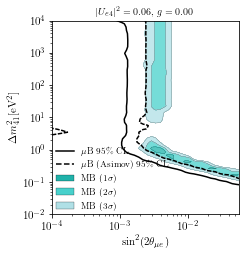

In [53]:
# Filter entries for fixed g and e
slice_g = data[data[:,0] == gvalue]
slice_e = slice_g[slice_g[:,2] == evalue]
MiniApp_chi2 = slice_e[:,-3]
MicroApp_chi2 = slice_e[:,-2]
MicroApp_Asimov_chi2 = slice_e[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = 4 * evalue * slice_e[:,3], slice_e[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 0.89*evalue, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax.set_title('$|U_{e4}|^2=%.2f$, $g=%.2f$'%(evalue,gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
#fig.set_size_inches(3.2*2, 1.5 * 2.3617*2)
fig.savefig(f"{micro.path_plots}/slice1.pdf", bbox_inches='tight', dpi=300)


## 2D scan

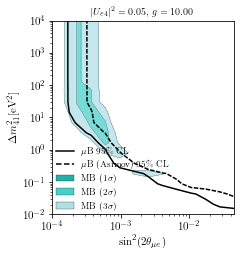

In [8]:
# 2D parameter scan
filename = 'g=10_std_test'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.npy", allow_pickle=True)
evalue = 0.05
gvalue = 10
# Filter entries for fixed g and e
MiniApp_chi2 = data[:,-3]
MicroApp_chi2 = data[:,-2]
MicroApp_Asimov_chi2 = data[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = 4 * evalue * data[:,3], data[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 0.89*evalue, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax.set_title('$|U_{e4}|^2=%.2f$, $g=%.2f$'%(evalue,gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
fig.savefig(f"{micro.path_plots}/{filename}.pdf", bbox_inches='tight', dpi=300)


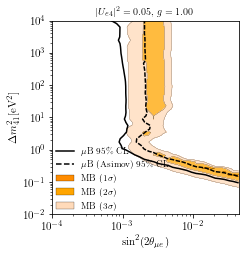

In [140]:
# Oscillation only
# 4D parameter scan
filename = 'g=1e=0.05_nobar_osc'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.npy", allow_pickle=True)
evalue = 0.05
gvalue = 1
# Filter entries for fixed g and e
MiniApp_chi2 = data[:,-3]
MicroApp_chi2 = data[:,-2]
MicroApp_Asimov_chi2 = data[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = 4 * evalue * data[:,3], data[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 0.89*evalue, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax.set_title('$|U_{e4}|^2=%.2f$, $g=%.2f$'%(evalue,gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
fig.savefig(f"{micro.path_plots}/{filename}.pdf", bbox_inches='tight', dpi=300)


## decoupled

In [5]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
def create_grid_of_params(g, m4, Ue4Sq, Um4Sq):
    paramlist_decay = np.array(np.meshgrid(g, m4, Ue4Sq, Um4Sq)).T.reshape(-1, 4)
    return [{"g": g, "m4": m4, "Ue4Sq": Ue4Sq, "Um4Sq": Um4Sq} for g, m4, Ue4Sq, Um4Sq in paramlist_decay]

path_results = "fit_data/"
Npoints = 30

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 0.89, Npoints)

# Range of m4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=1, m4=y_Vec, Ue4Sq=0, Um4Sq=x_Vec)

# Pure oscillation method
func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs_deGouvea)
# Note: numu disappearance is on
# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_osc, paramlist_decay)
#np.save(f"{path_results}/App_gm4_Um4sq_osc_decay_deg_g=0.1_Ue4Sq=0.05_test", res)
np.save(f"{path_results}/g=1_decoupled", res)

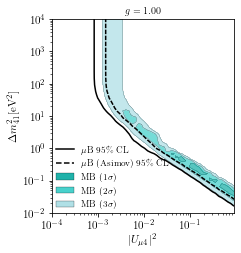

In [6]:
# deGouvea 2D parameter scan
filename = 'g=1_decoupled'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.npy", allow_pickle=True)
gvalue = 1
# Filter entries for fixed g and e
MiniApp_chi2 = data[:,-3]
MicroApp_chi2 = data[:,-2]
MicroApp_Asimov_chi2 = data[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = data[:,3], data[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 0.89, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
ax.set_title('$g=%.2f$'%(gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
fig.savefig(f"{micro.path_plots}/{filename}.pdf", bbox_inches='tight', dpi=300)


## Test migration matrix

In [ ]:
import MiniTools as mini

# load all MC samples
Ereco_nue, Etrue_nue, Length_nue, Weight_nue = mini.apps.get_MC_from_data_release_nue(mode="fhc", year="2022" )
Ereco_numu, Etrue_numu, Length_numu, Weight_numu = (mini.apps.get_MC_from_data_release_numu(mode="fhc", year="2022"))
Ereco_nuebar, Etrue_nuebar, Length_nuebar, Weight_nuebar = (mini.apps.get_MC_from_data_release_nue(mode="rhc", year="2022"))
Ereco_numubar, Etrue_numubar, Length_numubar, Weight_numubar = (mini.apps.get_MC_from_data_release_numu(mode="rhc", year="2022"))

# Pre-computed migration matrices
migration_matrix_official_bins_numu = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_numu.pkl"
)
migration_matrix_official_bins_nue_11bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nue_11bins.pkl"
)
migration_matrix_official_bins_nue_13bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nue_13bins.pkl"
)

migration_matrix_official_bins_numubar = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_numubar.pkl"
)
migration_matrix_official_bins_nuebar_11bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nuebar_11bins.pkl"
)
migration_matrix_official_bins_nuebar_13bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nuebar_13bins.pkl"
)

bins = param_scan.MB_Ereco_official_bins
bin_w = np.diff(bins)
bins_numu = param_scan.MB_Ereco_official_bins_numu
bin_numu_w = np.diff(bins_numu)

mig_rate_nue = np.dot(
    param_scan.fast_histogram(
        Etrue_nue, bins=param_scan.e_prod_e_int_bins, weights=Weight_nue
    )[0],
    migration_matrix_official_bins_nue_11bins,
)

std_rate_nue=param_scan.fast_histogram(Ereco_nue, weights=Weight_nue, bins = bins)[0]

mig_rate_nuebar = np.dot(
    param_scan.fast_histogram(
        Etrue_nuebar, bins=param_scan.e_prod_e_int_bins, weights=Weight_nuebar
    )[0],
    migration_matrix_official_bins_nuebar_11bins,
)

std_rate_nuebar=param_scan.fast_histogram(Ereco_nuebar, weights=Weight_nuebar, bins = bins)[0]

mig_rate_numu = np.dot(
    param_scan.fast_histogram(
        Etrue_numu, bins=param_scan.e_prod_e_int_bins_numu, weights=Weight_numu
    )[0],
    migration_matrix_official_bins_numu,
)

std_rate_numu=param_scan.fast_histogram(Ereco_numu, weights=Weight_numu, bins = bins_numu)[0]

mig_rate_numubar = np.dot(
    param_scan.fast_histogram(
        Etrue_numubar, bins=param_scan.e_prod_e_int_bins_numu, weights=Weight_numubar
    )[0],
    migration_matrix_official_bins_numubar,
)

std_rate_numubar=param_scan.fast_histogram(Ereco_numubar, weights=Weight_numubar, bins = bins_numu)[0]

plt.hist(bins[:-1], weights=1 - std_rate_nue/mig_rate_nue, bins = bins,color='red', histtype='step', label=r'$\nu_e$ rate')
plt.hist(bins[:-1], weights=1 - std_rate_nuebar/mig_rate_nuebar, bins = bins,color='blue', histtype='step', label=r'$\bar\nu_e$ rate')
plt.hist(bins_numu[:-1], weights=1 - std_rate_numu/mig_rate_numu, bins = bins_numu,color='red', histtype='step', ls='--', label=r'$\nu_\mu$ rate')
plt.hist(bins_numu[:-1], weights=1 - std_rate_numubar/mig_rate_numubar, bins = bins_numu,color='blue', histtype='step', ls='--', label=r'$\bar\nu_\mu$ rate')
# plt.step(bins[:-1], std_rate/mig_rate, where='post')
plt.axhline(0, c='black', lw=0.5, ls='--')
plt.xlabel(r'$E_\nu$/GeV')
plt.ylabel(r' $\delta$ = 1 - (binned MC) / (migr matrix)')
plt.xlim(0.0,3)
plt.ylim(-0.02,0.08)
plt.legend()
plt.title("Error introduced when using migr matrix instead of MC samples", fontsize=10)
plt.savefig('plots/error_introduced_migr_matrix.pdf', bbox_inches='tight')
plt.rcParams['figure.figsize'] = [8, 5]

In [ ]:
plt.hist(bins[:-1], weights=mig_rate_nue, bins = bins,color='red', histtype='step', label=r'migrated $\nu_e$ rate')
plt.hist(bins[:-1], weights=std_rate_nue, bins = bins,color='blue', histtype='step', label=r'MC $\nu_e$ rate')
plt.hist(bins_numu[:-1], weights=mig_rate_numu, bins = bins_numu,color='red', histtype='step', ls='--', label=r'migrated $\nu_\mu$ rate')
plt.hist(bins_numu[:-1], weights=std_rate_numu, bins = bins_numu,color='blue', histtype='step', ls='--', label=r'MC $\nu_\mu$ rate')
# plt.step(bins[:-1], std_rate/mig_rate, where='post')
plt.axhline(0, c='black', lw=0.5, ls='--')
plt.xlabel(r'$E_\nu$/GeV')
plt.ylabel(r' Event rate')
plt.xlim(0.0,3)
#plt.ylim(-0.02,0.08)
plt.legend()
plt.title("Event rate from migr matrix vs. MC samples", fontsize=10)
plt.savefig('plots/event_rate_migr_matrix.pdf', bbox_inches='tight')
plt.rcParams['figure.figsize'] = [8, 5]

## Compare with IceCube 95%

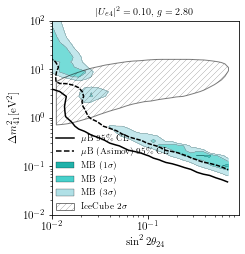

In [46]:
# 2D parameter scan
filename = 'g=2.8e=0.1'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.npy", allow_pickle=True)
evalue = 0.1
gvalue = 2.8
# Filter entries for fixed g and e
MiniApp_chi2 = data[:,-3]
MicroApp_chi2 = data[:,-2]
MicroApp_Asimov_chi2 = data[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = 4 * data[:,3]*(1-data[:,3]), data[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-2, 0.89, 1e-2, 1e2
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$\sin^2{2\theta_{24}}$", fontproperties=pt.font)
ax.set_title('$|U_{e4}|^2=%.2f$, $g=%.2f$'%(evalue,gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

# icecube 2022 data
ice_upper = np.loadtxt("MiniTools/include/IceCube2022/2sigma_contour_upper.dat")
ice_lower = np.loadtxt("MiniTools/include/IceCube2022/2sigma_contour_lower.dat")
fupper = interp1d(y = ice_upper[:,1], x = ice_upper[:,0], bounds_error=False, fill_value='extrapolate')
flower = interp1d(y = ice_lower[:,1], x = ice_lower[:,0], bounds_error=False, fill_value='extrapolate')
x = np.geomspace(np.min([ice_upper[:,0].min(), ice_lower[:,0].min()]), np.max([ice_upper[:,0].max(), ice_lower[:,0].max()]))
ax.fill_between(x, fupper(x), flower(x), where = flower(x) <= fupper(x), edgecolor='black', hatch='////', facecolor='None', alpha=0.5, label='IceCube $2\sigma$')

ax.legend(loc=(0,0), fontsize=9)
fig.savefig(f"{micro.path_plots}/{filename}_icecube.pdf", bbox_inches='tight', dpi=300)


## 2D slices from 3D deGouvea scan

In [56]:
# 4D parameter scan
filename = 'KJK_decoupled.pkl'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}", allow_pickle=True)
g = np.unique(data[:,0])
print('g:', min(g),max(g), len(g))
m = np.unique(data[:,1])
print('m:', min(m),max(m), len(m))
mu = np.unique(data[:,3])
print('mu:', min(mu),max(mu), len(mu))
# find the best fit point
idx = np.argmin(data[:,-3])
print('best fit:', data[idx])

g: 0.01 3.5 50
m: 0.1 100.0 50
mu: 0.0001 0.49 50
best fit: [  0.40692319   0.54286754   0.           0.41198932  25.918248
 116.02410604  17.34241969]


In [59]:
labels_slices = [r'$g_e$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_e$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
# 0 is g, 1 is m4, 2 is Ue4Sq, 3 is Um4Sq
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(filename, xi=3, yi=1, zi=0, global_deltachi2=False):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    
    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z = get_var(data,xi), get_var(data,yi), get_var(data,zi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min= x[i_min], y[i_min], z[i_min]
    
    z_slices = np.geomspace(np.min(z), np.max(z),9,endpoint=True)
    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
    # plt.subplots_adjust(hspace=0, wspace=0)
    axs = axs.flatten()
    for i, z_slice in enumerate(z_slices):
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)

        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i in [0,3,6]:
            ax.set_ylabel(string_slices[yi], fontproperties=pt.font)
        # else:
            # ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[xi], fontproperties=pt.font)
        else:
            ax.set_xticklabels([])
        ax.annotate(text=fr"{string_slices[zi]} $\,= {z_slice_true:.3f}$", 
                    xycoords='axes fraction', 
                    xy=(0.05,0.9), 
                    fontsize=11, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))

        le = len(np.unique(x))
        kwargs_interp = {'fine_gridx': le,  
                        'fine_gridy': le, 
                        'logx':True, 
                        'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
            cs = ax.contourf(X,Y,Z, levels=[0, 3.53, 8.02, 14.16], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
            cs = ax.contour(X,Y,Z, levels=[3.53, 8.02, 14.16], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
            cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
            cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
            cs = ax.contour(X,Y,Z, levels=[8.02], colors=['black'], zorder=2)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
            cs = ax.contour(X,Y,Z, levels=[6.18], colors=['black'], zorder=2)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
            cs = ax.contour(X,Y,Z, levels=[8.02], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)
            cs = ax.contour(X,Y,Z, levels=[6.18], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', color='black',)
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on")
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        if i == 0:
            ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
            ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
            ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
            ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')
            ax.legend(loc=(0,0), fontsize=8)
    #fig.suptitle(fr'{string_slices[wi]} $\,= {w_fixed:.2f}$')
    #fig.savefig(f"{micro.path_plots}/{filename}_allslices_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=300)



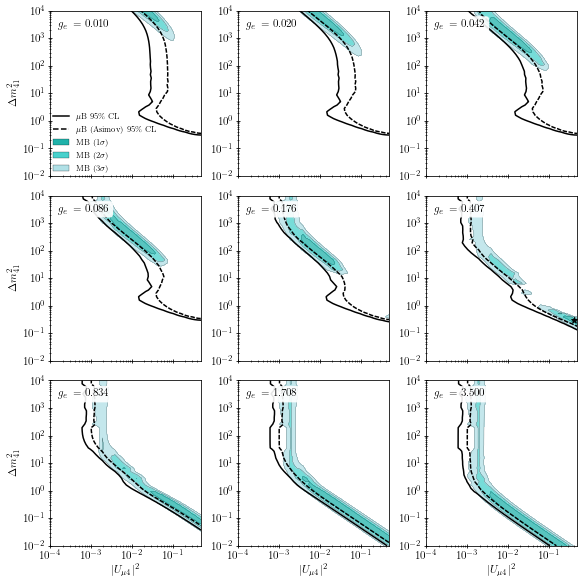

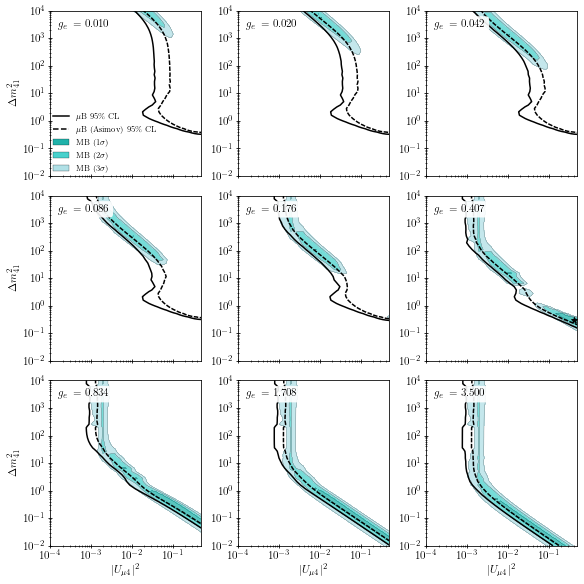

In [60]:
plot_all_slices('KJK_decoupled', xi=3, yi=1, zi=0, global_deltachi2=False)
plot_all_slices('KJK_decoupled', xi=3, yi=1, zi=0, global_deltachi2=True)

## PGOF

best fit: 36.0003563505351
best fit: 35.60610562677607
PGOF1: [3.286700317605778, 3.4026136558397866, 3.5488463850761036, 3.731012516183938, 3.9683904970645614, 4.270369178409368, 4.660115130138678, 5.1706649750731515, 5.87381397860625, 6.790873393381233, 8.03043899826126, 9.680405352604964, 11.89310322910228, 13.722449944318626, 14.679967421197404, 13.716993108182805, 12.808833976881786, 13.435128588778085, 14.086185935401147, 14.76687097725491, 15.496039835628522, 15.960770006645461, 16.74265509254508, 16.875239233637046, 16.32967848508585, 15.337859790181497, 14.309422115620038, 14.101740960053277, 14.57564464730531, 14.353833352323349, 14.303040580401372, 14.44787519020916, 14.342046128729663, 14.41969523560833, 14.383967105102414, 14.374284997506834, 14.401582957596261, 14.314038533040403, 14.309411648097111, 14.365465987273097]
PGOF2: [3.307060988435495, 3.4203574948456037, 3.566713389743626, 3.7484573288867438, 3.985278153888686, 4.286443299778625, 4.674700429523142, 5.212059492

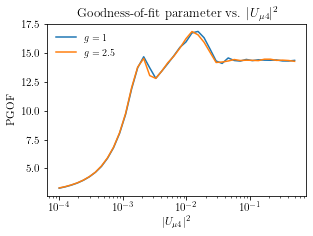

In [53]:
# parameter goodness of fit for 3D scan
filename1 = 'MH_decay_gfixed_1.0_3D_40'
filename2 = 'MH_decay_gfixed_2.5_3D_40'
path_results = "fit_data/"
data1 = np.load(f"{path_results}/{filename1}.pkl", allow_pickle=True)
data2 = np.load(f"{path_results}/{filename2}.pkl", allow_pickle=True)

def data_func(data):
    dic = {}
    # Coupling
    dic["g"] = np.unique(data[:,0])
    # Mass
    dic["m"] = np.unique(data[:,1])
    # Ue4Sq
    dic["e"] = np.unique(data[:,2])
    # Um4Sq
    dic["mu"] = np.unique(data[:,3])
    # best fit
    idx = np.argmin(data[:,-3])
    dic["bf"] = data[idx, -3]
    print('best fit:', data[idx, -3])
    return dic

data_dic1 = data_func(data1)
data_dic2 = data_func(data2)

Npoints = 40

def PGOF_func(Npoints, data, x, n):
    PGOF = []
    for i in range(Npoints):
        slice = data[data[:, n] == x[i], :]
        chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
        chi_sq_BFP_MiniApp = np.min(slice[:, -3])
        chi_sq_BFP_MicroApp = np.min(slice[:, -2])
        PGOF.append(chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp)
    return PGOF
PGOF1 = PGOF_func(Npoints, data1, data_dic1["mu"], 3)
PGOF2 = PGOF_func(Npoints, data2, data_dic2["mu"], 3)

print('PGOF1:', PGOF1)
print('PGOF2:', PGOF2)
plt.plot(data_dic1["mu"], PGOF1, label = r'$g=1$')
plt.plot(data_dic2["mu"], PGOF2, label = r'$g=2.5$')
plt.title(r'Goodness-of-fit parameter vs. $|U_{\mu 4}|^2$', fontsize=13)
plt.ylabel(r'PGOF')
plt.xlabel(r'$|U_{\mu 4}|^2$')
plt.xscale('log')
plt.legend()
plt.subplots_adjust(left=0.16, right=0.97,bottom=0.15, top=0.93)
plt.savefig(f"{micro.path_plots}/PGOF_Um4sq.pdf", bbox_inches='tight', dpi=300)

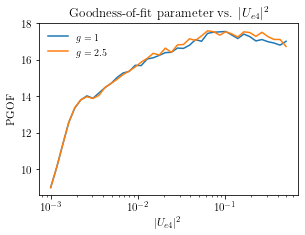

In [27]:
PGOF1_e = PGOF_func(Npoints, data1, data_dic1["e"], 2)
PGOF2_e = PGOF_func(Npoints, data2, data_dic2["e"], 2)
plt.plot(data_dic1["e"], PGOF1_e, label = r'$g=1$')
plt.plot(data_dic2["e"], PGOF2_e, label = r'$g=2.5$')
plt.title(r'Goodness-of-fit parameter vs. $|U_{e 4}|^2$', fontsize=13)
plt.ylabel(r'PGOF')
plt.xlabel(r'$|U_{e 4}|^2$')
plt.xscale('log')
plt.legend()
plt.subplots_adjust(left=0.16, right=0.97,bottom=0.15, top=0.93)
plt.savefig(f"{micro.path_plots}/PGOF_Ue4sq.pdf", bbox_inches='tight', dpi=300)

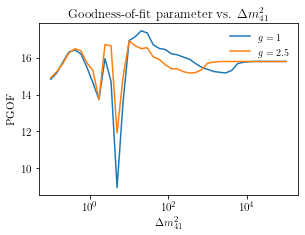

In [54]:
PGOF1_m = PGOF_func(Npoints, data1, data_dic1["m"], 1)
PGOF2_m = PGOF_func(Npoints, data2, data_dic2["m"], 1)
plt.plot(data_dic1["m"]**2, PGOF1_m, label = r'$g=1$')
plt.plot(data_dic2["m"]**2, PGOF2_m, label = r'$g=2.5$')
plt.title(r'Goodness-of-fit parameter vs. $\Delta m_{41}^2$', fontsize=13)
plt.ylabel(r'PGOF')
plt.xlabel(r'$\Delta m_{41}^2$')
plt.xscale('log')
plt.legend()
plt.subplots_adjust(left=0.16, right=0.97,bottom=0.15, top=0.93)
plt.savefig(f"{micro.path_plots}/PGOF_m.pdf", bbox_inches='tight', dpi=300)

In [29]:
slice = data1
chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
chi_sq_BFP_MiniApp = np.min(slice[:, -3])
chi_sq_BFP_MicroApp = np.min(slice[:, -2])
PGOF_global=chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp
print('PGOF_global:', PGOF_global)


PGOF_global: 17.720525716380394


In [30]:
slice = data2
chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
chi_sq_BFP_MiniApp = np.min(slice[:, -3])
chi_sq_BFP_MicroApp = np.min(slice[:, -2])
PGOF_global=chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp
print('PGOF_global:', PGOF_global)

PGOF_global: 17.563070246654334


35.326818621185694
[3.16227766e-01 4.01280703e-01 5.09209564e-01 6.46167079e-01
 8.19960824e-01 1.04049831e+00 1.32035178e+00 1.67547492e+00
 2.12611233e+00 2.69795364e+00 3.42359796e+00 4.34441230e+00
 5.51288979e+00 6.99564216e+00 8.87719709e+00 1.12648169e+01
 1.42946134e+01 1.81393069e+01 2.30180731e+01 2.92090372e+01
 3.70651291e+01 4.70342034e+01 5.96845700e+01 7.57373918e+01
 9.61077966e+01 1.21957046e+02 1.54758735e+02 1.96382800e+02
 2.49202115e+02 3.16227766e+02]
PGOF: 25


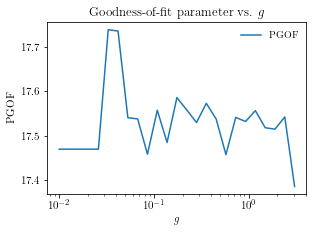

In [87]:
filename = 'MH_decay_4D_30'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.pkl", allow_pickle=True)

def data_func(data):
    dic = {}
    # Coupling
    dic["g"] = np.unique(data[:,0])
    # Mass
    dic["m"] = np.unique(data[:,1])
    # Ue4Sq
    dic["e"] = np.unique(data[:,2])
    # Um4Sq
    dic["mu"] = np.unique(data[:,3])
    # best fit
    idx = np.argmin(data[:,-3])
    dic["bf"] = data[idx, -3]
    return dic

data_dic = data_func(data)
print(data_dic["bf"])

print(data_dic["m"])

# which parameter to slice over
Npoints = 25
n = 0
x = data_dic["g"]

PGOF = []
for i in range(Npoints):
    slice = data[data[:, n] == x[i], :]
    chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
    chi_sq_BFP_MiniApp = np.min(slice[:, -3])
    chi_sq_BFP_MicroApp = np.min(slice[:, -2])
    PGOF.append(chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp)

print('PGOF:', len(PGOF))

plt.plot(data_dic["g"], PGOF, label = 'PGOF')
plt.title(r'Goodness-of-fit parameter vs. $g$', fontsize=13)
plt.ylabel(r'PGOF')
plt.xlabel(r'$g$')
plt.xscale('log')
plt.legend()
plt.subplots_adjust(left=0.16, right=0.97,bottom=0.15, top=0.93)
plt.savefig(f"{micro.path_plots}/PGOF.pdf", bbox_inches='tight', dpi=300)


## constrained mixing

35.326818621185694
25
PGOF: 25


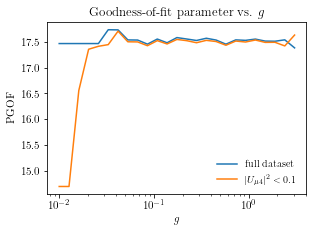

In [67]:
filename = 'MH_decay_4D_30'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.pkl", allow_pickle=True)

def data_func(data):
    dic = {}
    # Coupling
    dic["g"] = np.unique(data[:,0])
    # Mass
    dic["m"] = np.unique(data[:,1])
    # Ue4Sq
    dic["e"] = np.unique(data[:,2])
    # Um4Sq
    dic["mu"] = np.unique(data[:,3])
    # best fit
    idx = np.argmin(data[:,-3])
    dic["bf"] = data[idx, -3]
    return dic

data_dic = data_func(data)
print(data_dic["bf"])

print(len(data_dic["g"]))

data_cut = data[(data[:,2] < 1) & (data[:,3] < 0.01), :]

# which parameter to slice over
Npoints = 25
n = 0
x = data_dic["g"]

PGOF_cut = []
for i in range(Npoints):
    slice = data_cut[data_cut[:, n] == x[i], :]
    chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
    chi_sq_BFP_MiniApp = np.min(slice[:, -3])
    chi_sq_BFP_MicroApp = np.min(slice[:, -2])
    PGOF_cut.append(chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp)

print('PGOF:', len(PGOF))

plt.plot(data_dic["g"], PGOF, label = 'full dataset')
plt.plot(data_dic["g"], PGOF_cut, label = '$|U_{\mu 4}|^2< 0.1$')
plt.title(r'Goodness-of-fit parameter vs. $g$', fontsize=13)
plt.ylabel(r'PGOF')
plt.xlabel(r'$g$')
plt.xscale('log')
plt.legend()
plt.subplots_adjust(left=0.16, right=0.97,bottom=0.15, top=0.93)
plt.savefig(f"{micro.path_plots}/PGOF_g_cut.pdf", bbox_inches='tight', dpi=300)


35.326818621185694
0.0001 0.5
PGOF: 25


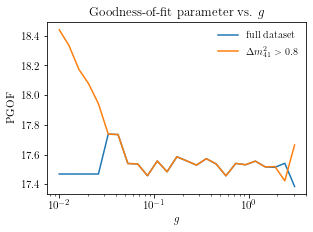

In [64]:
filename = 'MH_decay_4D_30'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.pkl", allow_pickle=True)

def data_func(data):
    dic = {}
    # Coupling
    dic["g"] = np.unique(data[:,0])
    # Mass
    dic["m"] = np.unique(data[:,1])
    # Ue4Sq
    dic["e"] = np.unique(data[:,2])
    # Um4Sq
    dic["mu"] = np.unique(data[:,3])
    # best fit
    idx = np.argmin(data[:,-3])
    dic["bf"] = data[idx, -3]
    return dic

data_dic = data_func(data)
print(data_dic["bf"])

print(np.min(data_dic["mu"]), np.max(data_dic["mu"]))

data_cut = data[data[:,1] > np.sqrt(0.8), :]

# which parameter to slice over
Npoints = 25
n = 0
x = data_dic["g"]

PGOF_cut = []
for i in range(Npoints):
    slice = data_cut[data_cut[:, n] == x[i], :]
    chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
    chi_sq_BFP_MiniApp = np.min(slice[:, -3])
    chi_sq_BFP_MicroApp = np.min(slice[:, -2])
    PGOF_cut.append(chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp)

print('PGOF:', len(PGOF))

plt.plot(data_dic["g"], PGOF, label = 'full dataset')
plt.plot(data_dic["g"], PGOF_cut, label = '$\Delta m_{41}^2 > 0.8$')
plt.title(r'Goodness-of-fit parameter vs. $g$', fontsize=13)
plt.ylabel(r'PGOF')
plt.xlabel(r'$g$')
plt.xscale('log')
plt.legend()
plt.subplots_adjust(left=0.16, right=0.97,bottom=0.15, top=0.93)
plt.savefig(f"{micro.path_plots}/PGOF_g_cut.pdf", bbox_inches='tight', dpi=300)


## oscillation only

In [43]:
filename = 'MH_fullosc_3D_50'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.pkl", allow_pickle=True)

slice = data
chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
chi_sq_BFP_MiniApp = np.min(slice[:, -3])
chi_sq_BFP_MicroApp = np.min(slice[:, -2])
PGOF_global=chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp
print('PGOF_global:', PGOF_global)


PGOF_global: 17.740926739503507


In [57]:
filename = 'MH_decay_4D_30'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.pkl", allow_pickle=True)

slice = data
chi_sq_BFP_JointFit = np.min(slice[:, -3]+slice[:, -2])
chi_sq_BFP_MiniApp = np.min(slice[:, -3])
chi_sq_BFP_MicroApp = np.min(slice[:, -2])

idx = np.argmin(data[:,-3])
print('best-fit g, m, e, mu, chi2', data[idx,0], data[idx,1], data[idx,2], data[idx,3], data[idx,-3])
PGOF_global=chi_sq_BFP_JointFit - chi_sq_BFP_MiniApp - chi_sq_BFP_MicroApp
print('PGOF_global:', PGOF_global)

best-fit g, m, e, mu, chi2 3.039195382313198 0.31622776601683794 0.20716573966075624 0.1544426500964737 35.326818621185694
PGOF_global: 17.385601798290367


In [59]:
from MicroTools import param_scan 
dic_osc_full = param_scan.load_scan_data('fit_data/MH_fullosc_3D_50.pkl')
dic_dec_full = param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl')

bf_osc_full = param_scan.get_best_fit_point(dic_osc_full)
bf_dec_full = param_scan.get_best_fit_point(dic_dec_full)

print('Osc best-fit',bf_osc_full)
print('Decay best-fit',bf_dec_full)

Osc best-fit {'g': 1.0, 'm4': 0.4192267435236917, 'Ue4Sq': 0.03070347655351973, 'Um4Sq': 0.4202239692272256, 'sin2theta': 0.051609, 'dm4SQR': 0.1757510624854792, 'MiniApp_chi2': 36.30074851672007, 'MicroApp_chi2': 113.69345377952513, 'MicroApp_Asimov_chi2': 14.516761338027042, 'MiniApp_deltachi2': 0.0, 'MicroApp_deltachi2': 23.83622745608743, 'MicroApp_Asimov_deltachi2': 11.707652459498084}
Decay best-fit {'g': 3.039195382313198, 'm4': 0.31622776601683794, 'Ue4Sq': 0.20716573966075624, 'Um4Sq': 0.1544426500964737, 'sin2theta': 0.127981, 'dm4SQR': 0.1, 'MiniApp_chi2': 35.326818621185694, 'MicroApp_chi2': 114.81965634304564, 'MicroApp_Asimov_chi2': 15.540302026438336, 'MiniApp_deltachi2': 0.0, 'MicroApp_deltachi2': 24.84108307403018, 'MicroApp_Asimov_deltachi2': 12.73117346682438}


In [65]:
def make_mass_vs_mixing_plot(dic, mixing='Umu4SQR', name='default', suffix='default', plot_IC=False, plot_Asimov=True, microColor='darkorange', microColor_2='grey', cmap_color='steelblue', n_sigmas=4, cmin=0.05, cmax=0.95, modelII=False, minos_file=None):
    fig, ax1 = pt.std_fig(figsize=(3.2, 1.2 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$" if mixing =='Umu4SQR' else r"$|U_{e 4}|^2$", fontproperties=pt.font)
    ax1.set_title(name, fontsize=9)
    ax1.set_ylim(dic['dm4SQR'].min(), dic['dm4SQR'].max())
    # ax1.set_ylim(1e4, dic['dm4SQR'].max())
    ax1.set_xlim(dic[mixing].min(), dic[mixing].max())
    # ax1.set_xlim(dic[mixing].min(), 0.2)

    kwargs_interp = {'fine_gridx': len(np.unique(dic[mixing])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True,
                    'method': 'interpolate',
                    }
    
    colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
    X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2']), **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=colors, zorder=1, alpha=1)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['black'], linewidths=0.25, zorder=1, alpha=1)
    # ax1.scatter(dic['Umu4SQR'], dic['dm4SQR'], c=np.log10(dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2'])),)
    ax1.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='black', edgecolor='black', lw=0.5, zorder=10)

    X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MicroApp_chi2']-np.min(dic['MicroApp_chi2']), **kwargs_interp)
    # cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2)+[np.inf], edgecolors=['None'], colors=['grey'], zorder=2)
    cs = ax1.contour(X,Y,Z, levels=[pt.get_chi2vals_w_sigma(2,2),pt.get_chi2vals_w_sigma(3,2)], colors=[microColor,microColor], zorder=2, linewidths=1.5, linestyles=['-', (1,(3,0.5))])
    # cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=[microColor], zorder=2)
    ax1.plot([], [], color=microColor, lw=1.5, label='$\mu$B 2$\sigma$')
    ax1.plot([], [], color=microColor, lw=1.5, ls=(1,(3,0.5)), label='$\mu$B 3$\sigma$')

    if plot_Asimov:
        X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MicroApp_Asimov_chi2']-np.min(dic['MicroApp_Asimov_chi2']), **kwargs_interp)
        cs = ax1.contour(X,Y,Z, levels=[pt.get_chi2vals_w_sigma(3,2)], colors=[microColor_2], linestyles=[(1,(3,0.5))], linewidths=1.5, zorder=2)
        ax1.plot([], [], color=microColor_2, lw=1.5, ls=(1,(3,0.5)), label='$\mu$B $3\sigma$ (Asimov)')
    
    # ------ get the legend-entries that are already attached to the axis
    # ------ get the legend-entries that are already attached to the axis
    h, l = ax1.get_legend_handles_labels()
    mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
    leg1 = ax1.legend([pt.MulticolorPatch(colors)], [mb_label], loc='upper right', fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()}, facecolor='white', edgecolor='None', frameon=True, framealpha=0.8)
    leg2 = ax1.legend(h, l, loc=(0.025,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()}, facecolor='white', edgecolor='None', frameon=True, framealpha=0.7)
    ax1.add_artist(leg1)
    # ax1.add_artist(leg2)

    if plot_IC:
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2024_95CL.dat', unpack=True)
        x,y = pt.get_ordered_closed_region([x,y], logx=True, logy=True)
        ax1.fill(x, y, facecolor='orange', edgecolor='darkorange', lw=0.5, ls='-', alpha=0.25, hatch='')
        ax1.annotate('95\% CL', xy=(0.068, 2.8), xycoords='data', rotation=18, color='darkorange', fontsize=9)
        ax1.annotate('IC 99\% CL', xy=(0.048, 0.5), xycoords='data', rotation=18, color='darkorange', fontsize=9)
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2024_99CL.dat', unpack=True)
        ax1.plot(x, y, color='darkorange', lw=1, ls='-', alpha=1,zorder=4)
        if modelII:
            ax1.fill_betweenx([0,1e10], [4.1e-2, 4.1e-2], [1,1], facecolor='grey', edgecolor='grey', lw=0.5, ls='-', alpha=0.15, hatch='')
            ax1.vlines(4.1e-2,0,1e10, color='grey', lw=0.5, ls='-')
            ax1.annotate(r'SK 90\% CL', xy=(4.8e-2, ax1.get_ylim()[1]/200), xycoords='data', rotation=90, color='grey', fontsize=7, zorder=3)
            ax1.set_yticklabels(ax1.get_yticks()/1e6)
            ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{keV^2}]$', fontproperties=pt.font)
            
            # MINOS/MINOS+
            # ax1.fill_betweenx([0,1e10], [3.8e-2, 3.8e-2], [1,1], facecolor='orange', edgecolor='darkorange', lw=0.5, ls='-', alpha=0.15, hatch='')
            # # ax1.fill_betweenx([0,1e10], [7.3e-2, 7.3e-2], [1,1], facecolor='orange', edgecolor='darkorange', lw=0.5, ls='-', alpha=0.15, hatch='')
            # ax1.vlines(3.8e-2,0,1e10, color='darkorange', lw=0.5, ls='-')
            # ax1.annotate(r'\noindent MINOS 90\% CL', xy=(2.8e-2, ax1.get_ylim()[1]/300), xycoords='data', rotation=90, color='darkorange', fontsize=7, zorder=3)
            if minos_file is not None:
                g_minos, th24, dm241, chi2 = np.genfromtxt(minos_file, unpack=True, )
                sin22theta24 = np.sin(2*th24)**2
                kwargs_interp = {'fine_gridx': len(np.unique(sin22theta24)),  
                                'fine_gridy': len(np.unique(dm241)), 
                                'logx':True, 
                                'logy':True,
                                'method': 'interpolate',
                                }
                X, Y, Z = pt.interp_grid(sin22theta24, dm241, chi2 - np.min(chi2), **kwargs_interp)
                cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.9], 1), colors=['darkorange'], linewidths=1.0, zorder=1, alpha=1)
                cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.9,1], 1), colors=['orange'], linewidths=1.0, zorder=1, alpha=0.15)

        else:
            ax1.annotate('SK 90\% CL', xy=(6e-2, ax1.get_ylim()[1]/300), xycoords='data', rotation=90, color='grey', fontsize=9)
        
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2024_99CL.dat', unpack=True)
        ax1.plot(x, y, color='darkorange', lw=1, ls='-', alpha=1,zorder=4)
        # x, y = np.genfromtxt(f"MicroTools/osc_data/numu_dis/MINOSPlus_90CL.csv", delimiter=",", unpack=True)
        # plt.plot(x, y/(1e-3)**2, color='darkorange', lw=1, ls=(1,(3,1)), alpha=1)

    fig.savefig(f"{micro.path_plots}/MH_decay_{mixing}_profiled_{suffix}.pdf", bbox_inches='tight', dpi=350)

In [ ]:
CMAP = 'steelblue'
microColor='black'
microColor_2 = 'darkorange'
from scipy.sparse import spmatrix

kwargs = {'plot_IC': True, 'plot_Asimov': True, 'microColor': microColor, 'microColor_2': microColor_2, 'cmap_color': CMAP, 'n_sigmas': 4, 'cmin': 0.2, 'cmax': 1}

# dic_dec_gfixed_2p5_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.05_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_2p5_small = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.01_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_2p5_small, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.01$', suffix='gfixed_2.5_small', **kwargs)
# dic_dec_gfixed_2p5_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.05_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_2p5_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.05_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_2p5_solar, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.05$', suffix='gfixed_2.5_solar', **kwargs)
# dic_dec_gfixed_2p5_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.10_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_2p5_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.10_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_2p5_BEST, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.1$', suffix='gfixed_2.5_BEST', **kwargs)


dic_dec_gfixed_1p0_small = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1_Ue4SQRfixed_0.01_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_1p0_small, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.01$', suffix='gfixed_1.0_small', **kwargs)
# dic_dec_gfixed_1p0_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_Ue4SQRfixed_0.05_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_1p0_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1_Ue4SQRfixed_0.05_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_1p0_solar, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.05$', suffix='gfixed_1.0_solar', **kwargs)
# dic_dec_gfixed_1p0_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_Ue4SQRfixed_0.10_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_1p0_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1_Ue4SQRfixed_0.10_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_1p0_BEST, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=1.0$ $\vert$ $|U_{e4}|^2 = 0.1$', suffix='gfixed_1.0_BEST', **kwargs)